In [ ]:
# Instala o pacote trimesh com todas as dependências extras
!pip install trimesh[all]

# Importa os módulos necessários para manipulação de arquivos, gráficos 3D, processamento de dados, e construção de modelos.
import os  # Para interagir com o sistema de arquivos.
import glob  # Para localizar arquivos e diretórios usando padrões especificados.
import trimesh  # Biblioteca para manipulação de malhas 3D.
import numpy as np  # Biblioteca para manipulação de arrays e operações numéricas.
from tensorflow import data as tf_data  # Para manipulação eficiente de conjuntos de dados no TensorFlow.
from keras import ops  # Contém utilitários relacionados a operações.
import keras  # Biblioteca de alto nível para construção de redes neurais.
from keras import layers  # Módulo para criar camadas de modelos.
from matplotlib import pyplot as plt  # Para visualização e geração de gráficos.

# Define uma semente fixa para reprodutibilidade nos resultados gerados pelo Keras.
keras.utils.set_random_seed(seed=42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of matplotlib to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.1/26.1 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 9

/usr/local/lib/python3.10/dist-packages/numpy/_core/_dtype.py:106: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if dtype.type == np.bool:
/usr/local/lib/python3.10/dist-packages/numpy/_core/_dtype.py:106: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if dtype.type == np.bool:


In [ ]:
# Faz o download do dataset ModelNet10 e o descompacta automaticamente.
# `get_file` baixa o arquivo ZIP do URL especificado e o salva em um diretório temporário.
DATA_DIR = keras.utils.get_file(
    "modelnet.zip",  # Nome local do arquivo ZIP após o download.
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",  # URL do dataset.
    extract=True,  # Indica que o arquivo ZIP deve ser extraído após o download.
)

# Define o caminho final para o diretório "ModelNet10" dentro do diretório onde o arquivo foi extraído.
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [ ]:
# Carrega uma malha 3D de um arquivo no formato .off usando a biblioteca trimesh.
# O caminho para o arquivo é construído combinando o diretório base (DATA_DIR) e o subdiretório específico do modelo "chair/train/chair_0001.off".
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))

# Exibe a malha 3D carregada em uma janela interativa para visualização.
mesh.show()

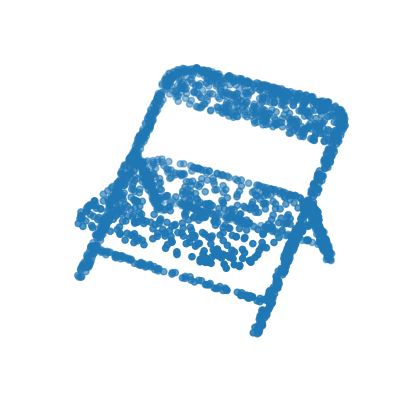

In [ ]:
# Realiza uma amostragem uniforme de 2048 pontos na superfície da malha 3D.
points = mesh.sample(2048)

# Cria uma figura para visualização 3D dos pontos amostrados.
fig = plt.figure(figsize=(5, 5))  # Define o tamanho da figura.
ax = fig.add_subplot(111, projection="3d")  # Adiciona um subplot 3D à figura.

# Plota os pontos amostrados em um gráfico 3D usando um scatter plot.
ax.scatter(points[:, 0], points[:, 1], points[:, 2])  # As coordenadas x, y e z são obtidas das colunas do array `points`.

# Desativa os eixos para focar apenas na visualização dos pontos.
ax.set_axis_off()

# Exibe o gráfico com os pontos amostrados.
plt.show()

In [ ]:
def parse_dataset(num_points=2048):
    """
    Processa o dataset ModelNet10, amostrando pontos das malhas 3D e classificando-as por classes.

    Args:
        num_points (int): Número de pontos a serem amostrados de cada malha 3D.

    Returns:
        tuple: Uma tupla contendo:
            - train_points (numpy.ndarray): Pontos amostrados das malhas de treinamento.
            - test_points (numpy.ndarray): Pontos amostrados das malhas de teste.
            - train_labels (numpy.ndarray): Rótulos das malhas de treinamento.
            - test_labels (numpy.ndarray): Rótulos das malhas de teste.
            - class_map (dict): Mapeamento de índices para nomes de classes.
    """
    # Inicializa listas para armazenar pontos e rótulos das malhas de treinamento e teste.
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []

    # Dicionário para mapear IDs de classes aos seus respectivos nomes.
    class_map = {}

    # Localiza todos os diretórios de classes, excluindo o arquivo README.
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    # Itera sobre as classes (pastas) no diretório.
    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))  # Exibe a classe em processamento.

        # Armazena o nome da classe associado ao índice.
        class_map[i] = folder.split("/")[-1]

        # Localiza todos os arquivos de treinamento e teste na pasta da classe.
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        # Processa os arquivos de treinamento.
        for f in train_files:
            # Amostra pontos da malha e armazena-os na lista de pontos de treinamento.
            train_points.append(trimesh.load(f).sample(num_points))
            # Adiciona o rótulo correspondente.
            train_labels.append(i)

        # Processa os arquivos de teste.
        for f in test_files:
            # Amostra pontos da malha e armazena-os na lista de pontos de teste.
            test_points.append(trimesh.load(f).sample(num_points))
            # Adiciona o rótulo correspondente.
            test_labels.append(i)

    # Converte as listas para arrays numpy e retorna os resultados.
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [ ]:
# Define constantes para o número de pontos amostrados por malha, número de classes no dataset e tamanho do batch.
NUM_POINTS = 2048  # Número de pontos amostrados de cada malha 3D.
NUM_CLASSES = 10  # Número total de classes no dataset ModelNet10.
BATCH_SIZE = 32  # Tamanho do batch usado no treinamento do modelo.

# Chama a função `parse_dataset` para processar o dataset ModelNet10.
# Retorna os conjuntos de pontos, rótulos e o mapeamento das classes.
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS  # Número de pontos a serem amostrados por malha.
)

processing class: night_stand
processing class: sofa
processing class: dresser
processing class: bathtub
processing class: chair
processing class: table
processing class: monitor
processing class: toilet
processing class: bed
processing class: desk


In [ ]:
def augment(points, label):
    """
    Aplica augmentação aos pontos de entrada para melhorar a robustez do modelo.

    Args:
        points (numpy.ndarray): Pontos amostrados da malha 3D.
        label (int): Rótulo associado aos pontos.

    Returns:
        tuple: Pontos modificados (jitter e embaralhamento) e o rótulo correspondente.
    """
    # Aplica jitter aos pontos, adicionando ruído aleatório em um intervalo pequeno.
    points += keras.random.uniform(points.shape, -0.005, 0.005, dtype="float64")

    # Embaralha a ordem dos pontos para garantir invariância à ordem.
    points = keras.random.shuffle(points)

    return points, label


# Define a proporção do conjunto de dados que será usada para treinamento.
train_size = 0.8  # 80% para treinamento, 20% para validação.

# Converte os arrays de pontos e rótulos em objetos do tipo `tf.data.Dataset`.
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))  # Dados de treinamento.
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))  # Dados de teste.

# Calcula o tamanho do conjunto de treinamento com base na proporção definida.
train_dataset_size = int(len(dataset) * train_size)

# Embaralha os dados de treinamento e aplica a função de augmentação.
dataset = dataset.shuffle(len(train_points)).map(augment)

# Embaralha e cria batches no conjunto de dados de teste.
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

# Divide o conjunto embaralhado em treinamento e validação.
# Toma os primeiros `train_dataset_size` exemplos como conjunto de treinamento.
train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)

# Pula os primeiros `train_dataset_size` exemplos e usa o restante como conjunto de validação.
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/numpy/_core/_dtype.py:106: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if dtype.type == np.bool:


In [ ]:
def conv_bn(x, filters):
    """
    Aplica uma camada de convolução 1D seguida de normalização em lote (Batch Normalization)
    e uma ativação ReLU.

    Args:
        x (tensor): Entrada para a camada convolucional.
        filters (int): Número de filtros da camada convolucional.

    Returns:
        tensor: Saída após a convolução, normalização em lote e ativação ReLU.
    """
    # Aplica uma convolução 1D com kernel de tamanho 1 e sem preenchimento adicional (padding "valid").
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)

    # Aplica normalização em lote para estabilizar e acelerar o treinamento.
    x = layers.BatchNormalization(momentum=0.0)(x)

    # Retorna o tensor com a ativação ReLU aplicada.
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    """
    Aplica uma camada densa (fully connected) seguida de normalização em lote (Batch Normalization)
    e uma ativação ReLU.

    Args:
        x (tensor): Entrada para a camada densa.
        filters (int): Número de neurônios (unidades) na camada densa.

    Returns:
        tensor: Saída após a camada densa, normalização em lote e ativação ReLU.
    """
    # Aplica uma camada densa com o número especificado de unidades.
    x = layers.Dense(filters)(x)

    # Aplica normalização em lote para estabilizar e acelerar o treinamento.
    x = layers.BatchNormalization(momentum=0.0)(x)

    # Retorna o tensor com a ativação ReLU aplicada.
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """
    Regularizador personalizado para impor ortogonalidade em uma matriz de pesos, penalizando desvios da identidade.
    A ortogonalidade é importante para melhorar a estabilidade e a convergência do treinamento de redes neurais.

    Args:
        num_features (int): Número de características (features) da matriz de pesos.
        l2reg (float): Coeficiente de regularização L2 para controlar a magnitude da penalização. O valor padrão é 0.001.
    """
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features  # Define o número de características da matriz de pesos.
        self.l2reg = l2reg  # Coeficiente de regularização L2.
        self.eye = ops.eye(num_features)  # Cria a matriz identidade para comparação com a matriz X^T * X.

    def __call__(self, x):
        """
        Calcula o valor do regularizador para a entrada `x`, que é uma matriz de pesos.

        Args:
            x (tensor): A matriz de pesos para a qual a regularização será aplicada.

        Returns:
            tensor: O valor da penalização ortogonal aplicada à matriz de pesos.
        """
        # Redimensiona `x` para ter a forma adequada de (batch_size, num_features, num_features).
        x = ops.reshape(x, (-1, self.num_features, self.num_features))

        # Calcula o produto tensorial de x com sua transposta (X^T * X).
        xxt = ops.tensordot(x, x, axes=(2, 2))

        # Redimensiona a matriz resultado para garantir que tenha a forma correta.
        xxt = ops.reshape(xxt, (-1, self.num_features, self.num_features))

        # Calcula a penalização L2 entre X^T * X e a matriz identidade (xxt - eye).
        # A penalização é controlada pelo valor `l2reg`.
        return ops.sum(self.l2reg * ops.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features):
    """
    Cria uma rede neural para calcular uma transformação afim (affine transformation) nos dados de entrada,
    utilizando uma rede de convoluções e camadas densas, além de aplicar regularização ortogonal.

    Args:
        inputs (tensor): Tensor de entrada contendo as características a serem transformadas.
        num_features (int): Número de características para a matriz de transformação (deve ser um valor que permita uma matriz quadrada).

    Returns:
        tensor: Saída da transformação afim aplicada aos dados de entrada.
    """
    # Inicializa o viés como a matriz identidade, achatada para um vetor.
    bias = keras.initializers.Constant(np.eye(num_features).flatten())

    # Cria o regularizador ortogonal para garantir que a matriz de transformação seja aproximadamente ortogonal.
    reg = OrthogonalRegularizer(num_features)

    # Aplica a primeira camada convolucional com batch normalization e ReLU.
    x = conv_bn(inputs, 32)

    # Aplica a segunda camada convolucional com batch normalization e ReLU.
    x = conv_bn(x, 64)

    # Aplica a terceira camada convolucional com batch normalization e ReLU.
    x = conv_bn(x, 512)

    # Aplica uma camada de pooling global para reduzir a dimensionalidade.
    x = layers.GlobalMaxPooling1D()(x)

    # Aplica uma camada densa com normalização em lote e ReLU.
    x = dense_bn(x, 256)

    # Aplica uma segunda camada densa com normalização em lote e ReLU.
    x = dense_bn(x, 128)

    # Aplica uma camada densa para calcular a matriz de transformação afim (num_features x num_features),
    # com inicialização de pesos zerada e o viés inicializado como a matriz identidade.
    x = layers.Dense(
        num_features * num_features,  # A camada precisa gerar uma matriz num_features x num_features.
        kernel_initializer="zeros",  # Inicializa os pesos como zeros.
        bias_initializer=bias,  # Inicializa o viés como a matriz identidade.
        activity_regularizer=reg,  # Aplica o regularizador ortogonal.
    )(x)

    # Redimensiona a saída da camada densa para obter uma matriz quadrada (num_features x num_features).
    feat_T = layers.Reshape((num_features, num_features))(x)

    # Aplica a transformação afim nos dados de entrada, multiplicando os dados pela matriz de transformação.
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
# Define a entrada para o modelo, especificando o formato dos dados de entrada (NUM_POINTS pontos, 3 coordenadas por ponto).
inputs = keras.Input(shape=(NUM_POINTS, 3))

# Aplica a primeira rede de transformação afim (tnet) aos dados de entrada, resultando em uma transformação afim.
x = tnet(inputs, 3)

# Aplica duas camadas convolucionais seguidas de batch normalization e ReLU.
x = conv_bn(x, 32)
x = conv_bn(x, 32)

# Aplica uma segunda rede de transformação afim (tnet) para refinar a transformação.
x = tnet(x, 32)

# Aplica mais camadas convolucionais com batch normalization e ReLU.
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)

# Aplica pooling global para reduzir a dimensionalidade e obter a representação global dos pontos.
x = layers.GlobalMaxPooling1D()(x)

# Aplica camadas densas com batch normalization e ReLU.
x = dense_bn(x, 256)

# Aplica uma camada de dropout com taxa de 0.3 para evitar overfitting.
x = layers.Dropout(0.3)(x)

# Aplica mais uma camada densa com batch normalization e ReLU.
x = dense_bn(x, 128)

# Aplica outra camada de dropout para regularizar a rede.
x = layers.Dropout(0.3)(x)

# Aplica a camada de saída com ativação softmax para classificar os pontos em uma das `NUM_CLASSES` classes.
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# Cria o modelo Keras com os dados de entrada e saída definidos acima.
model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")

# Exibe um resumo da arquitetura do modelo.
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2048, 3)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 2048, 32)       │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 2048, 32)       │            128 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 2048, 32)       │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 2048, 64)       │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 2048, 64)       │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 2048, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 2048, 512)      │         33,280 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 2048, 512)      │          2,048 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 2048, 512)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 512)            │              0 │ activation_2[0][0]     │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128)            │            512 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 748,979 (2.86 MB)

 Trainable params: 742,899 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [ ]:
# Compila o modelo especificando a função de perda, o otimizador e as métricas de avaliação.
model.compile(
    loss="sparse_categorical_crossentropy",  # Função de perda para classificação multiclasse, onde os rótulos são inteiros.
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Otimizador Adam com taxa de aprendizado de 0.001.
    metrics=["sparse_categorical_accuracy"],  # Métrica de precisão para classificação com rótulos inteiros.
)

# Treina o modelo utilizando o dataset de treinamento e validação.
# O modelo será treinado por 20 épocas.
model.fit(
    train_dataset,  # Conjunto de dados de treinamento.
    epochs=20,  # Número de épocas para treinamento.
    validation_data=validation_dataset,  # Conjunto de dados de validação para monitorar o desempenho durante o treinamento.
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 242ms/step - loss: 46.1362 - sparse_categorical_accuracy: 0.2145 - val_loss: 264239088402432.0000 - val_sparse_categorical_accuracy: 0.3379
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 36.1961 - sparse_categorical_accuracy: 0.3243 - val_loss: 1033103530640015360.0000 - val_sparse_categorical_accuracy: 0.3842
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 35.9779 - sparse_categorical_accuracy: 0.3635 - val_loss: 37697582268416.0000 - val_sparse_categorical_accuracy: 0.4255
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 36.0201 - sparse_categorical_accuracy: 0.3960 - val_loss: 1836043399422587961344.0000 - val_sparse_categorical_accuracy: 0.4956
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 35.8652 - sparse_categorical_accuracy: 0.4049 - val_loss: 41937263268986880.0000 - val_sparse_categorical_accuracy: 0.4468
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 35.7553 - s

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


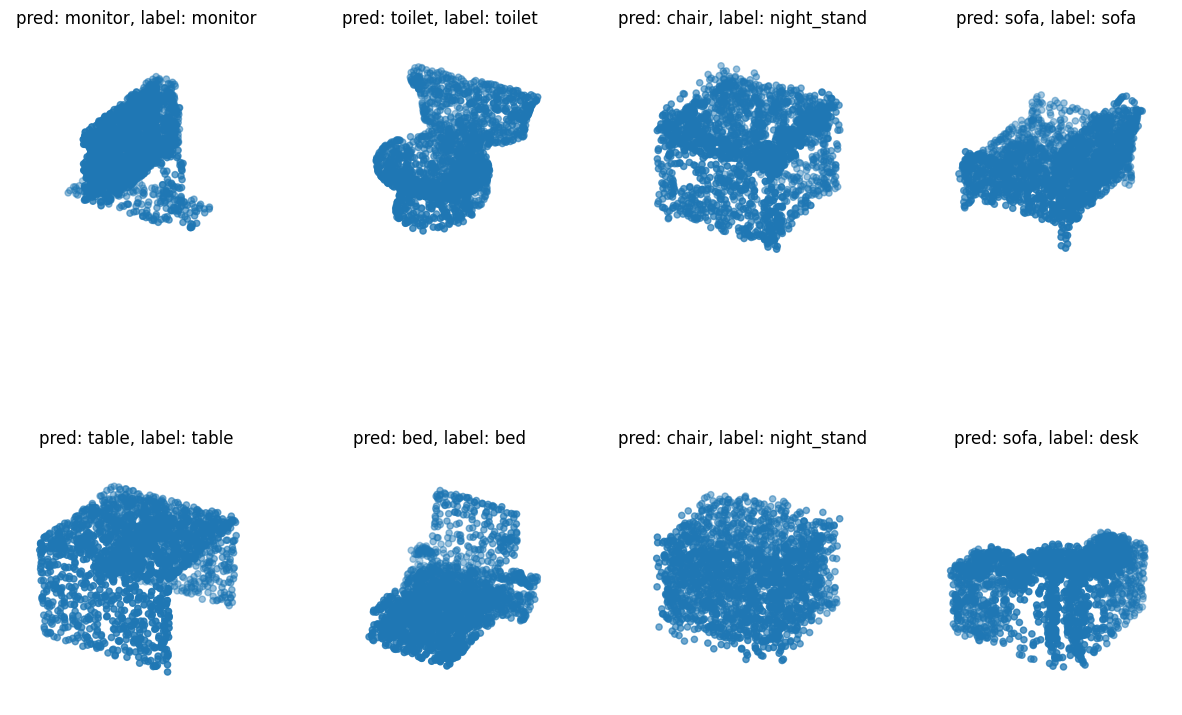

In [ ]:
# Seleciona um batch de teste a partir do dataset.
data = test_dataset.take(1)  # Pega o primeiro batch de teste.

# Extrai os pontos e rótulos do primeiro batch.
points, labels = list(data)[0]

# Seleciona apenas os primeiros 8 exemplos para visualização.
points = points[:8, ...]  # Seleciona os primeiros 8 pontos.
labels = labels[:8, ...]  # Seleciona os primeiros 8 rótulos.

# Faz previsões utilizando o modelo treinado.
preds = model.predict(points)  # Faz a previsão com o modelo.
preds = ops.argmax(preds, -1)  # Converte as previsões para índices de classe (classe com maior probabilidade).

# Converte os pontos para um formato NumPy.
points = points.numpy()

# Cria uma figura para plotar os pontos e suas classes previstas e reais.
fig = plt.figure(figsize=(15, 10))  # Define o tamanho da figura.
for i in range(8):
    # Cria um gráfico 3D para cada ponto no batch.
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")

    # Plota os pontos 3D para o i-ésimo exemplo.
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])

    # Define o título do gráfico com a classe prevista e a classe real.
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()],  # Classe prevista (mapeada para o nome da classe).
            CLASS_MAP[labels.numpy()[i]]  # Classe real (mapeada para o nome da classe).
        )
    )
    # Desliga os eixos para melhor visualização dos pontos.
    ax.set_axis_off()

# Exibe o gráfico com todos os exemplos.
plt.show()